# MFHT Rolling Windows Plot
plt.close('all')

In [1]:
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime

from stabilvol.utility import functions as f

DATABASE = '../data/processed/trapezoidal_selection/stabilvol.sqlite'
# Connect to the SQLite database
conn = sqlite3.connect(DATABASE)
cur = conn.cursor()

In [2]:
import os
print(os.getcwd())
os.path.exists(DATABASE)

G:\UNIPA\ECONOFISICA\stabilizing_volatility\notebooks


True

In [3]:
MARKETS = ["UN", "UW", "LN", "JT"]
START_DATE = "1980-01-01"
END_DATE = "2022-07-01"

T1_STRING = "m0p5"
T2_STRING = "m1p5"

START_LEVELS = [-2.0, -1.0, -0.5, -0.2, -0.1, 0.1, 0.2, 0.5, 1.0, 2.0]
DELTAS = [2.0, 1.0, 0.5, 0.2, 0.1, -0.1, -0.2, -0.5, -1.0, -2.0]
LEVELS = {
    (start, round(start+delta, 2)) for start in START_LEVELS for delta in DELTAS
}
LEVELS = sorted(LEVELS)

VOL_LIMIT= 0.5  # Change this will change all the pickle files, remember to re-generate them

In [4]:
def select_bins(df, max_n=1000):
    nbins = 25
    
    while True:
        # Use qcut to bin 'Volatility' values
        df['Bins'] = pd.qcut(df['Volatility'], nbins, duplicates='drop')
        
        # Group by the bins and calculate the mean and standard error of 'value'
        grouped = df.groupby('Bins')['FHT'].agg(['mean', error_on_the_mean, 'size'])
        count = grouped['size'].min()
        
        if count < max_n or nbins > 1000:
            break
        else:
            nbins += 20
    return grouped, nbins

def error_on_the_mean(values):
    return np.std(values)/np.sqrt(len(values))

In [5]:
def query_binned_data(market: str, start_date:str, end_date:str = None, vol_limit:float = 0.5, t1_string:str = "m0p5", t2_string:str = "m1p5"):
    grouped_data = None
    end_date = '2023-01-01' if end_date is None else end_date
    try:            
        # Write the SQL query
        query = f'''
        SELECT *
        FROM stabilvol_{t1_string}_{t2_string}
        WHERE Volatility < {vol_limit} 
        AND Market = "{market}"
        AND start >= "{start_date}"
        AND end <= "{end_date}"    
        '''
        # Load the FHT data from the database
        df = pd.read_sql_query(query, conn)
    except pd.errors.DatabaseError:
        print(f'No data for market {market} with thresholds {t1_string}-{t2_string}')
        nbins = 0
    else:
        if len(df) > 50:
            return  select_bins(df)
        else:
            raise ValueError(f'Not enough data for market {market} with thresholds {t1_string}-{t2_string} from {start_date} to {end_date}')

In [6]:
def create_dataset(windows, t1_string=T1_STRING, t2_string=T2_STRING):
    outcasts = {market: [] for market in MARKETS}
    df = pd.DataFrame()
    for market in MARKETS:
        for start_date, end_date in tqdm(windows, desc=market):
            try:
                mfht, nbins = query_binned_data(market, start_date, end_date, VOL_LIMIT, t1_string=t1_string, t2_string=t2_string)         
            except ValueError:
                outcasts[market].append((start_date, end_date))
            else:
                mfht['start'] = start_date
                mfht['end'] = end_date
                mfht['market'] = market
                df = pd.concat([df, mfht.reset_index()])
                
    return df, outcasts

## Rolling Windows

In [7]:
def roll_windows(duration=90,  start_date=None, end_date=None):
    # Define the start and end dates
    start_date = datetime.date(1980, 1, 1) if start_date is None else start_date
    end_date = datetime.date(2022, 7, 1) if end_date is None else end_date
    
    start = start_date + pd.to_timedelta(duration/2, 'D')
    end = end_date - pd.to_timedelta(duration/2, 'D')
    return [(mid - pd.to_timedelta(duration//2, 'D'), mid + pd.to_timedelta(duration//2, 'D')) for mid in pd.date_range(start, end, freq='D')]

In [8]:
windows = roll_windows(90, start_date=datetime.date(2000, 1, 1), end_date=datetime.date(2020, 1, 1))
len(windows)

7216

In [9]:
regenerate = False
if not os.path.exists(f'../data/processed/dynamics/rolling_MFHT_peaks_{T1_STRING}_{T2_STRING}_{VOL_LIMIT}.npy') or regenerate:
    # Data must be regenerate
    df, outcasts = create_dataset(windows)
    print(f"There are {len(outcasts)} outcasts")
    outcasts

JT: 100%|██████████| 7216/7216 [11:36<00:00, 10.37it/s]

There are 4 outcasts


It may be better to first save peaks data and then plot them

In [10]:
if not os.path.exists(f'../data/processed/dynamics/rolling_MFHT_peaks_{T1_STRING}_{T2_STRING}_{VOL_LIMIT}.npy') or regenerate:
    data = df.copy()
    max_values = np.zeros((len(MARKETS), len(windows)))
    for i, market in enumerate(MARKETS):
            for j, (start_date, end_date) in tqdm(enumerate(windows), desc=market):
    
                mfht = data[(data['market'] == market) & (data['start'] == start_date) & (data['end'] == end_date)]       
                if not mfht.empty:            
                    max_values[i, j] = mfht['mean'].max()
                    
    np.save(f'../data/processed/dynamics/rolling_MFHT_peaks_{T1_STRING}_{T2_STRING}_{VOL_LIMIT}.npy', max_values)
else:
    max_values = np.load(f'../data/processed/dynamics/rolling_MFHT_peaks_{T1_STRING}_{T2_STRING}_{VOL_LIMIT}.npy')

UN: 7216it [03:09, 38.10it/s]
UW: 7216it [03:11, 37.60it/s]
LN: 7216it [03:12, 37.46it/s]
JT: 7216it [03:11, 37.67it/s]


In [11]:
def add_ticks(ax, market, labels, outcasts, highlights=True):
    ax.set_xticks(np.arange(0.5, len(windows), 1)[::180], minor=False, labels=labels[::180], fontsize=11, rotation=90, ha='right', rotation_mode='anchor')
    ax.set_ylabel(market, fontsize=16)
    # Remove xticks
    ax.yaxis.set_ticks([])
    
    # Convert labels to Timestamps
    label_dates = pd.to_datetime(labels)
    outcast_dates = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in outcasts]
    for outcast in outcast_dates:
        # Find the indices of the start and end labels
        start_index = np.where(label_dates <= outcast[0])
        # Since only the end date is labeled, if the first start date is an outcast, it must be set manually
        start_index = start_index[0][-1] if len(start_index[0]) > 0 else 0
        end_index = np.where(label_dates >= outcast[1])[0][0]
        ax.axvspan(start_index-0.5, end_index-0.5, color='black')
    
    if highlights:
        # Find the indices of the start and end labels
        start_index = np.where(label_dates < pd.to_datetime('2007-01-01'))[0][-1]
        end_index = np.where(label_dates > pd.to_datetime('2009-01-01'))[0][0]
    
        # Add vertical lines at the start and end of the region
        ax.axvline(start_index-0.5, color='k', linestyle='--', linewidth=1.5)
        ax.axvline(end_index-0.5, color='k', linestyle='--', linewidth=1.5)


def plot_rolling_heatmap(windows, maxs=None, outcasts=None, **kwargs):
    toosmallwindows = 0
    if outcasts is None:
        outcasts = {market: [] for market in MARKETS}
        search_outcasts = True
    else:
        search_outcasts = False
    if kwargs.get('latex', False):    
        # Use LaTeX for text rendering
        plt.rcParams['text.usetex'] = True
        plt.rcParams['font.family'] = 'serif'
    
    fig, axs = plt.subplots(4, figsize=(12, 4), sharex=True)
    
    max_values = np.zeros((len(MARKETS), len(windows))) if maxs is None else maxs
    

    for i, (market, ax) in enumerate(zip(MARKETS, axs.flatten())):
        for j, (start_date, end_date) in enumerate(windows):
            if maxs is None:
                # Calculate the peaks
                mfht = data[(data['market'] == market) & (data['start'] == start_date) & (data['end'] == end_date)]       
                if mfht.empty:            
                    outcasts[market].append((start_date, end_date))
                else:
                    max_values[i, j] = mfht['mean'].max()
            elif search_outcasts:
                # See where the max is zero and label it as outcast
                if max_values[i, j] == 0:
                    outcasts[market].append((start_date, end_date))
                

        im = ax.imshow(max_values[i].reshape(1, -1), cmap='coolwarm', aspect='auto', vmin=max_values[i].min(), vmax=max_values[i].max())
         # Show ticks four by four and label them with the respective list entries
        labels = [end_date.strftime('%Y-%m-%d') for start_date, end_date in windows]
        add_ticks(ax, market, labels, outcasts[market])
    
    axs[0].text(0.3, 1.1, '2007-01-01', fontsize=11, transform=axs[0].transAxes, horizontalalignment='left')
    axs[0].text(0.48, 1.1, '2009-01-01', fontsize=11, transform=axs[0].transAxes, horizontalalignment='right')
    
    fig.tight_layout()

    # Add a colorbar
    cbar = fig.colorbar(im, ax=axs.ravel().tolist(), pad=0.01)
    cbar.set_label('Maximum MFHT', rotation=270, labelpad=15)

    plt.show()
    return fig, toosmallwindows

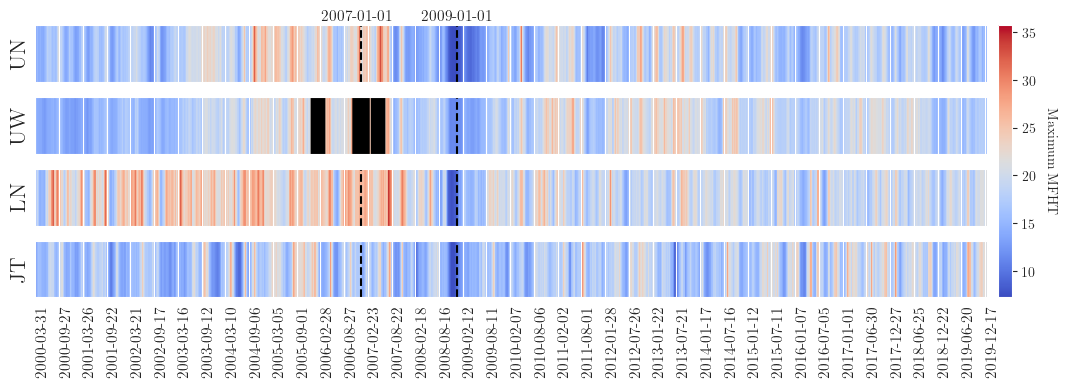

In [12]:
fig, errors = plot_rolling_heatmap(windows, max_values, outcasts if regenerate else None, latex=True)

In [ ]:
fig.savefig(f'../visualization/dynamics/rolling_windows/rolling_MFHT_peaks.png', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/rolling_MFHT_peaks.eps', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/rolling_MFHT_peaks.pdf', bbox_inches='tight')

In [ ]:
def take_maxs(df, t1_string, t2_string, windows, regenerate=False):
    if not os.path.exists(f'../data/processed/dynamics/rolling_MFHT_peaks_{t1_string}_{t2_string}_{VOL_LIMIT}.npy') or regenerate:  
        data = df.copy()
        max_values = np.zeros((len(MARKETS), len(windows)))
        for i, market in enumerate(MARKETS):
                for j, (start_date, end_date) in tqdm(enumerate(windows), desc=market):
        
                    mfht = data[(data['market'] == market) & (data['start'] == start_date) & (data['end'] == end_date)]       
                    if not mfht.empty:            
                        max_values[i, j] = mfht['mean'].max()
                        
        np.save(f'../data/processed/dynamics/rolling_MFHT_peaks_{t1_string}_{t2_string}_{VOL_LIMIT}.npy', max_values)
    else:
        max_values = np.load(f'../data/processed/dynamics/rolling_MFHT_peaks_{t1_string}_{t2_string}_{VOL_LIMIT}.npy')
    return max_values

## Rallies

Now we consider rallies

In [ ]:
t1_string = "1p0"
t2_string = "1p5"

In [ ]:
windows = roll_windows(90, start_date=datetime.date(2000, 1, 1), end_date=datetime.date(2020, 1, 1))
len(windows)

In [ ]:
regenerate = False
if not os.path.exists(f'../data/processed/dynamics/rolling_MFHT_peaks_{t1_string}_{t2_string}_{VOL_LIMIT}.npy') or regenerate:
    df, outcasts = create_dataset(windows, t1_string=t1_string, t2_string=t2_string)
    print(f"There are {len(outcasts)} outcasts") 
    outcasts

In [ ]:
max_values = take_maxs(df, t1_string, t2_string, windows, regenerate=regenerate)

In [ ]:
fig, errors = plot_rolling_heatmap(windows, max_values, outcasts if regenerate else None, latex=True)

In [ ]:
fig.savefig(f'../visualization/dynamics/rolling_windows/rolling_MFHT_peaks_{t1_string}_{t2_string}.png', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/rolling_MFHT_peaks_{t1_string}_{t2_string}.eps', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/rolling_MFHT_peaks_{t1_string}_{t2_string}.pdf', bbox_inches='tight')

## More Plots

Now we change the thresholds to see if something relevant changes

In [ ]:
# Crash
crash_thresholds2 = ("m2p0", "m2p2")

In [ ]:
regenerate = False
if not os.path.exists(f'../data/processed/dynamics/rolling_MFHT_peaks_{crash_thresholds2[0]}_{crash_thresholds2[1]}_{VOL_LIMIT}.npy') or regenerate:
    df, outcasts = create_dataset(windows, t1_string=crash_thresholds2[0], t2_string=crash_thresholds2[1])
    print(f"There are {len(outcasts)} outcasts")
    outcasts

In [ ]:
max_values = take_maxs(df, crash_thresholds2[0], crash_thresholds2[1], windows, regenerate=regenerate)

In [ ]:
fig, errors = plot_rolling_heatmap(windows, max_values, outcasts if regenerate else None, latex=True)

In [ ]:
fig.savefig(f'../visualization/dynamics/rolling_windows/rolling_MFHT_peaks_{crash_thresholds2[0]}_{crash_thresholds2[1]}.png', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/rolling_MFHT_peaks_{crash_thresholds2[0]}_{crash_thresholds2[1]}.eps', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/rolling_MFHT_peaks_{crash_thresholds2[0]}_{crash_thresholds2[1]}.pdf', bbox_inches='tight')

In [ ]:
# Rally
rally_thresholds2 = ("2p0", "2p2")

In [ ]:
regenerate = False
if not os.path.exists(f'../data/processed/dynamics/rolling_MFHT_peaks_{rally_thresholds2[0]}_{rally_thresholds2[1]}_{VOL_LIMIT}.npy') or regenerate:
    df, outcasts = create_dataset(windows, t1_string=rally_thresholds2[0], t2_string=rally_thresholds2[1])
    print(f"There are {len(outcasts)} outcasts")
    outcasts

In [ ]:
max_values = take_maxs(df, rally_thresholds2[0], rally_thresholds2[1], windows, regenerate=regenerate)

In [ ]:
fig, errors = plot_rolling_heatmap(windows, max_values, outcasts if regenerate else None, latex=True)

In [ ]:
fig.savefig(f'../visualization/dynamics/rolling_windows/rolling_MFHT_peaks_{rally_thresholds2[0]}_{rally_thresholds2[1]}.png', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/rolling_MFHT_peaks_{rally_thresholds2[0]}_{rally_thresholds2[1]}.eps', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/rolling_MFHT_peaks_{rally_thresholds2[0]}_{rally_thresholds2[1]}.pdf', bbox_inches='tight')